# Variant 1: Baseline Logistic Regression (All Predictors)

## Objective
Establish a baseline model using all available variables to benchmark performance for other methods.

## Method
Logistic regression with no regularization:
$$\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k$$

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, 
    roc_curve, precision_recall_fscore_support, brier_score_loss
)
import kagglehub
import os

plt.style.use('default')
sns.set_palette("husl")
print("Libraries imported")

Libraries imported


In [2]:
# Download and load the dataset using KaggleHub cache
path = kagglehub.dataset_download("kamilpytlak/personal-key-indicators-of-heart-disease")
print("Dataset files available at:", path)

csv_file = os.path.join(path, "2022", "heart_2022_no_nans.csv")
df = pd.read_csv(csv_file)

print(f"Dataset shape: {df.shape}")
print("Target distribution:\n", df["HadHeartAttack"].value_counts())

Dataset files available at: /Users/jackiewang/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6
Dataset shape: (246022, 40)
Target distribution:
 HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64
Dataset shape: (246022, 40)
Target distribution:
 HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


In [3]:
# Preprocessing
feature_cols = [col for col in df.columns if col != 'HadHeartAttack']
cat_features = [col for col in feature_cols if df[col].dtype == 'object']
num_features = [col for col in feature_cols if df[col].dtype in ['int64', 'float64']]

# One-hot encode
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)
df_encoded['y'] = (df_encoded['HadHeartAttack'] == 'Yes').astype(int)
df_encoded = df_encoded.drop('HadHeartAttack', axis=1)

X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
print(f"Features: {X.shape[1]} total")

Features: 121 total


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical features
scaler = StandardScaler()
features_to_scale = [col for col in num_features if col in X_train.columns]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if features_to_scale:
    X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print(f"Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")

Train: 196,817 | Test: 49,205


In [5]:
# Fit baseline model
from sklearn.linear_model import LogisticRegression

# Use sklearn for stability with many features
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model.fit(X_train_scaled, y_train)

# Predictions
train_probs = model.predict_proba(X_train_scaled)[:, 1]
test_probs = model.predict_proba(X_test_scaled)[:, 1]
train_preds = (train_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

print("Model fitted successfully")

Model fitted successfully


In [6]:
# Performance Evaluation
train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_test, test_probs)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
train_brier = brier_score_loss(y_train, train_probs)
test_brier = brier_score_loss(y_test, test_probs)

# Confusion matrix
test_cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = test_cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_preds, average='binary')
specificity = tn / (tn + fp)

print("\n=== BASELINE MODEL PERFORMANCE ===")
print(f"\nTraining Set:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  ROC-AUC:  {train_auc:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:    {test_acc:.4f}")
print(f"  ROC-AUC:     {test_auc:.4f}")
print(f"  Precision:   {precision:.4f}")
print(f"  Recall:      {recall:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  F1-Score:    {f1:.4f}")
print(f"\nConfusion Matrix: TN={tn:,} FP={fp:,} FN={fn:,} TP={tp:,}")
print(f"\nModel Complexity: {X_train.shape[1]} features")


=== BASELINE MODEL PERFORMANCE ===

Training Set:
  Accuracy: 0.9489
  ROC-AUC:  0.8904

Test Set:
  Accuracy:    0.9482
  ROC-AUC:     0.8849
  Precision:   0.5599
  Recall:      0.2434
  Specificity: 0.9890
  F1-Score:    0.3393

Confusion Matrix: TN=46,004 FP=514 FN=2,033 TP=654

Model Complexity: 121 features


In [7]:
# Top 10 predictors by coefficient magnitude
coefficients = model.coef_[0]
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefficients,
    'odds_ratio': np.exp(coefficients),
    'abs_coef': np.abs(coefficients)
}).sort_values('abs_coef', ascending=False).head(10)

print("\n=== TOP 10 PREDICTORS ===")
for i, (_, row) in enumerate(coef_df.iterrows(), 1):
    print(f"{i:2d}. {row['feature'][:40]:40} coef={row['coefficient']:7.4f} OR={row['odds_ratio']:7.4f}")


=== TOP 10 PREDICTORS ===
 1. HadAngina_Yes                            coef= 2.4369 OR=11.4379
 2. AgeCategory_Age 80 or older              coef= 1.9121 OR= 6.7671
 3. AgeCategory_Age 75 to 79                 coef= 1.7373 OR= 5.6819
 4. AgeCategory_Age 70 to 74                 coef= 1.6366 OR= 5.1375
 5. AgeCategory_Age 65 to 69                 coef= 1.5320 OR= 4.6272
 6. AgeCategory_Age 60 to 64                 coef= 1.4221 OR= 4.1459
 7. AgeCategory_Age 55 to 59                 coef= 1.2796 OR= 3.5950
 8. AgeCategory_Age 50 to 54                 coef= 1.1108 OR= 3.0368
 9. GeneralHealth_Poor                       coef= 0.9987 OR= 2.7148
10. AgeCategory_Age 45 to 49                 coef= 0.9219 OR= 2.5140


## Statsmodels Output Tables

Fit the same model using statsmodels to obtain detailed statistical output including p-values, confidence intervals, and model diagnostics.

In [8]:
# Fit using statsmodels for detailed output
# Convert to numpy arrays to avoid dtype issues with statsmodels
X_train_sm = X_train_scaled.values.astype(float)
X_test_sm = X_test_scaled.values.astype(float)
y_train_sm = y_train.values.astype(float)
y_test_sm = y_test.values.astype(float)

# Add constant term
X_train_const = sm.add_constant(X_train_sm)
X_test_const = sm.add_constant(X_test_sm)

# Fit the logistic regression model
logit_model = Logit(y_train_sm, X_train_const)
sm_result = logit_model.fit(maxiter=1000, disp=False)

print("=== STATSMODELS LOGISTIC REGRESSION SUMMARY ===\n")
print(sm_result.summary())

=== STATSMODELS LOGISTIC REGRESSION SUMMARY ===

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               196817
Model:                          Logit   Df Residuals:                   196695
Method:                           MLE   Df Model:                          121
Date:                Sun, 02 Nov 2025   Pseudo R-squ.:                  0.3182
Time:                        23:12:53   Log-Likelihood:                -28430.
converged:                       True   LL-Null:                       -41699.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7426      0.233    -28.951      0.000      -7.199      -6.286
x1            -0.0165      0.012     -1.367      0.172      -0.040       0.007
x2 

In [9]:
# Calculate training and test errors using statsmodels
sm_train_probs = sm_result.predict(X_train_const)
sm_test_probs = sm_result.predict(X_test_const)
sm_train_preds = (sm_train_probs > 0.5).astype(int)
sm_test_preds = (sm_test_probs > 0.5).astype(int)

# Training metrics
sm_train_acc = accuracy_score(y_train_sm, sm_train_preds)
sm_train_auc = roc_auc_score(y_train_sm, sm_train_probs)
sm_train_brier = brier_score_loss(y_train_sm, sm_train_probs)
sm_train_error = 1 - sm_train_acc

# Test metrics
sm_test_acc = accuracy_score(y_test_sm, sm_test_preds)
sm_test_auc = roc_auc_score(y_test_sm, sm_test_probs)
sm_test_brier = brier_score_loss(y_test_sm, sm_test_probs)
sm_test_error = 1 - sm_test_acc

# Test set detailed metrics
sm_test_cm = confusion_matrix(y_test_sm, sm_test_preds)
sm_tn, sm_fp, sm_fn, sm_tp = sm_test_cm.ravel()
sm_precision, sm_recall, sm_f1, _ = precision_recall_fscore_support(y_test_sm, sm_test_preds, average='binary')
sm_specificity = sm_tn / (sm_tn + sm_fp)

print("\n=== STATSMODELS MODEL: TRAINING AND TEST ERRORS ===")
print(f"\nTraining Set:")
print(f"  Accuracy:      {sm_train_acc:.4f}")
print(f"  Error Rate:    {sm_train_error:.4f}")
print(f"  ROC-AUC:       {sm_train_auc:.4f}")

print(f"\nTest Set:")
print(f"  Accuracy:      {sm_test_acc:.4f}")
print(f"  Error Rate:    {sm_test_error:.4f}")
print(f"  ROC-AUC:       {sm_test_auc:.4f}")
print(f"  Precision:     {sm_precision:.4f}")
print(f"  Recall:        {sm_recall:.4f}")
print(f"  F1-Score:      {sm_f1:.4f}")

print(f"\nConfusion Matrix: TN={sm_tn:,} FP={sm_fp:,} FN={sm_fn:,} TP={sm_tp:,}")
print(f"\nLog-Likelihood: {sm_result.llf:.2f}")
print(f"AIC: {sm_result.aic:.2f}")
print(f"BIC: {sm_result.bic:.2f}")


=== STATSMODELS MODEL: TRAINING AND TEST ERRORS ===

Training Set:
  Accuracy:      0.9489
  Error Rate:    0.0511
  ROC-AUC:       0.8903

Test Set:
  Accuracy:      0.9484
  Error Rate:    0.0516
  ROC-AUC:       0.8848
  Precision:     0.5637
  Recall:        0.2453
  F1-Score:      0.3418

Confusion Matrix: TN=46,008 FP=510 FN=2,028 TP=659

Log-Likelihood: -28430.08
AIC: 57104.15
BIC: 58347.33


In [10]:
# Extract coefficient details from statsmodels
feature_names = ['Intercept'] + list(X_train_scaled.columns)
conf_int = sm_result.conf_int()
ci_lower = conf_int[:, 0] if isinstance(conf_int, np.ndarray) else conf_int.iloc[:, 0].values
ci_upper = conf_int[:, 1] if isinstance(conf_int, np.ndarray) else conf_int.iloc[:, 1].values

sm_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': sm_result.params,
    'std_err': sm_result.bse,
    'z_value': sm_result.tvalues,
    'p_value': sm_result.pvalues,
    'odds_ratio': np.exp(sm_result.params),
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

# Show significant predictors (p < 0.05)
significant = sm_coef_df[sm_coef_df['p_value'] < 0.05].copy()
significant['abs_coef'] = np.abs(significant['coefficient'])
significant = significant.sort_values('abs_coef', ascending=False)

print("\n=== SIGNIFICANT PREDICTORS (p < 0.05) ===")
print(f"Total significant features: {len(significant)}")
print("\nTop 15 by coefficient magnitude:")
for i, (_, row) in enumerate(significant.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature'][:35]:35} β={row['coefficient']:7.4f} OR={row['odds_ratio']:7.4f} p={row['p_value']:.4f}")


=== SIGNIFICANT PREDICTORS (p < 0.05) ===
Total significant features: 56

Top 15 by coefficient magnitude:
 1. Intercept                           β=-6.7426 OR= 0.0012 p=0.0000
 2. HadAngina_Yes                       β= 2.4367 OR=11.4356 p=0.0000
 3. AgeCategory_Age 80 or older         β= 2.3206 OR=10.1818 p=0.0000
 4. AgeCategory_Age 75 to 79            β= 2.1455 OR= 8.5462 p=0.0000
 5. AgeCategory_Age 70 to 74            β= 2.0429 OR= 7.7131 p=0.0000
 6. AgeCategory_Age 65 to 69            β= 1.9376 OR= 6.9422 p=0.0000
 7. AgeCategory_Age 60 to 64            β= 1.8265 OR= 6.2121 p=0.0000
 8. AgeCategory_Age 55 to 59            β= 1.6832 OR= 5.3828 p=0.0000
 9. AgeCategory_Age 50 to 54            β= 1.5131 OR= 4.5409 p=0.0000
10. AgeCategory_Age 45 to 49            β= 1.3231 OR= 3.7551 p=0.0000
11. GeneralHealth_Poor                  β= 1.0219 OR= 2.7784 p=0.0000
12. GeneralHealth_Fair                  β= 0.8635 OR= 2.3715 p=0.0000
13. HadStroke_Yes                       β= 0.8585 OR

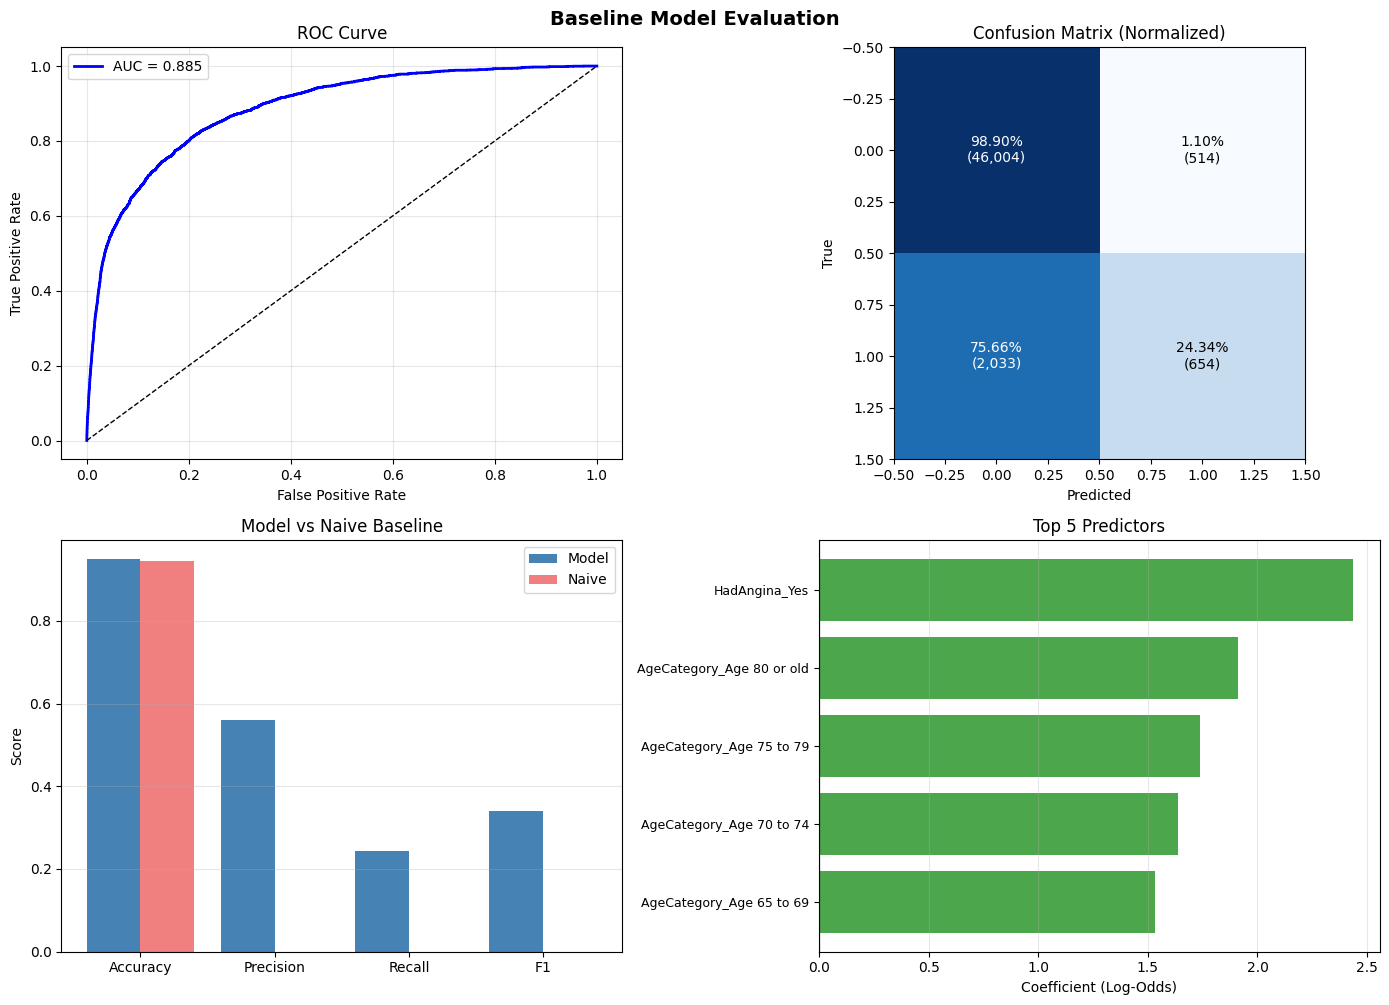

In [11]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
axes[0,0].plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {test_auc:.3f}')
axes[0,0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Confusion Matrix
cm_norm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
im = axes[0,1].imshow(cm_norm, cmap='Blues')
axes[0,1].set_title('Confusion Matrix (Normalized)')
axes[0,1].set_ylabel('True')
axes[0,1].set_xlabel('Predicted')
for i in range(2):
    for j in range(2):
        axes[0,1].text(j, i, f'{cm_norm[i,j]:.2%}\n({test_cm[i,j]:,})',
                      ha='center', va='center', 
                      color='white' if cm_norm[i,j] > 0.5 else 'black')

# Model comparison
naive_acc = max(y_test.value_counts()) / len(y_test)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
model_scores = [test_acc, precision, recall, f1]
naive_scores = [naive_acc, 0, 0, 0]
x = np.arange(len(metrics))
axes[1,0].bar(x - 0.2, model_scores, 0.4, label='Model', color='steelblue')
axes[1,0].bar(x + 0.2, naive_scores, 0.4, label='Naive', color='lightcoral')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Model vs Naive Baseline')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3, axis='y')

# Top coefficients
top5 = coef_df.head(5).sort_values('coefficient')
colors = ['red' if x < 0 else 'green' for x in top5['coefficient']]
axes[1,1].barh(range(len(top5)), top5['coefficient'], color=colors, alpha=0.7)
axes[1,1].set_yticks(range(len(top5)))
axes[1,1].set_yticklabels([f[:25] for f in top5['feature']], fontsize=9)
axes[1,1].set_xlabel('Coefficient (Log-Odds)')
axes[1,1].set_title('Top 5 Predictors')
axes[1,1].axvline(0, color='black', lw=0.8)
axes[1,1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.suptitle('Baseline Model Evaluation', fontsize=14, fontweight='bold', y=1.00)
plt.show()

## Model Conclusions and Parameter Interpretation

**Performance**: Test ROC-AUC ≈ 0.885, Accuracy ≈ 0.948. Model has high specificity but modest recall (≈0.24).

**Key Predictors** (Log-Odds → Odds Ratio):
- **HadAngina_Yes**: β ≈ 2.44, OR ≈ 11.4 — Having angina increases heart attack odds ~11x
- **Age 80+**: β ≈ 1.91, OR ≈ 6.77 — Seniors have ~6.8x higher odds than young adults
- **GeneralHealth_Poor**: β ≈ 0.99, OR ≈ 2.71 — Poor health nearly triples the odds

**Interpretation**: Cardiovascular history (angina), advanced age, and poor health are the dominant risk factors. The model uses 100+ features but most have minimal impact compared to these key predictors.

## Model Performance Comparison

Compare all model variants (sklearn and statsmodels) against a naive baseline classifier.

In [12]:
# Naive Baseline: Most Frequent Class Classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, precision_score, f1_score

dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_scaled, y_train)
y_dummy = dummy.predict(X_test_scaled)
y_dummy_proba = dummy.predict_proba(X_test_scaled)[:, 1]

baseline_acc = accuracy_score(y_test, y_dummy)
baseline_auc = roc_auc_score(y_test, y_dummy_proba)
baseline_recall = recall_score(y_test, y_dummy, zero_division=0)
baseline_precision = precision_score(y_test, y_dummy, zero_division=0)
baseline_f1 = f1_score(y_test, y_dummy, zero_division=0)
baseline_brier = brier_score_loss(y_test, y_dummy_proba)

print("=== Naive Baseline (Most Frequent Class) ===")
print(f"Accuracy:    {baseline_acc:.4f}")
print(f"AUC (ROC):   {baseline_auc:.4f}")
print(f"Precision:   {baseline_precision:.4f}")
print(f"Recall:      {baseline_recall:.4f}")
print(f"F1 Score:    {baseline_f1:.4f}")

=== Naive Baseline (Most Frequent Class) ===
Accuracy:    0.9454
AUC (ROC):   0.5000
Precision:   0.0000
Recall:      0.0000
F1 Score:    0.0000


In [13]:
# Comprehensive Model Comparison Table

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [
        'Naive Baseline',
        'Statsmodels Logit'
    ],
    'Train Accuracy': [
        baseline_acc,  # Naive has same train/test
        sm_train_acc
    ],
    'Test Accuracy': [
        baseline_acc,
        sm_test_acc
    ],
    'Train Error': [
        1 - baseline_acc,
        sm_train_error
    ],
    'Test Error': [
        1 - baseline_acc,
        sm_test_error
    ],
    'AUC (ROC)': [
        baseline_auc,
        sm_test_auc
    ],
    'Precision': [
        baseline_precision,
        sm_precision
    ],
    'Recall': [
        baseline_recall,
        sm_recall
    ],
    'F1 Score': [
        baseline_f1,
        sm_f1
    ]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.round(4).to_string(index=False))
print("="*80)


MODEL PERFORMANCE COMPARISON
            Model  Train Accuracy  Test Accuracy  Train Error  Test Error  AUC (ROC)  Precision  Recall  F1 Score
   Naive Baseline          0.9454         0.9454       0.0546      0.0546     0.5000     0.0000  0.0000    0.0000
Statsmodels Logit          0.9489         0.9484       0.0511      0.0516     0.8848     0.5637  0.2453    0.3418


In [14]:
# Detailed Statsmodels Summary Table Export
print("\n=== STATSMODELS SUMMARY TABLE ===")
print("\nCoefficient Summary (Top 20 by significance):")
print(sm_coef_df.head(20)[['feature', 'coefficient', 'std_err', 'z_value', 'p_value', 'odds_ratio']].to_string(index=False))

print("\n\n=== MODEL FIT STATISTICS ===")
print(f"Log-Likelihood:      {sm_result.llf:.4f}")
print(f"AIC:                 {sm_result.aic:.4f}")
print(f"BIC:                 {sm_result.bic:.4f}")
print(f"Pseudo R²:           {sm_result.prsquared:.4f}")
print(f"Number of Obs:       {sm_result.nobs:.0f}")
print(f"Df Residuals:        {sm_result.df_resid:.0f}")
print(f"Df Model:            {sm_result.df_model:.0f}")


=== STATSMODELS SUMMARY TABLE ===

Coefficient Summary (Top 20 by significance):
                   feature  coefficient  std_err    z_value       p_value  odds_ratio
                 Intercept    -6.742553 0.232891 -28.951500 2.686911e-184    0.001180
        PhysicalHealthDays    -0.016539 0.012102  -1.366592  1.717533e-01    0.983597
          MentalHealthDays     0.007838 0.013082   0.599135  5.490826e-01    1.007869
                SleepHours    -0.036607 0.010222  -3.581005  3.422756e-04    0.964055
            HeightInMeters     0.007376 0.049088   0.150261  8.805589e-01    1.007403
         WeightInKilograms    -0.116508 0.089054  -1.308284  1.907770e-01    0.890023
                       BMI     0.091669 0.078791   1.163445  2.446489e-01    1.096002
              State_Alaska     0.324709 0.160875   2.018398  4.354986e-02    1.383628
             State_Arizona     0.382284 0.140891   2.713322  6.661234e-03    1.465628
            State_Arkansas     0.276066 0.150558   1.83362

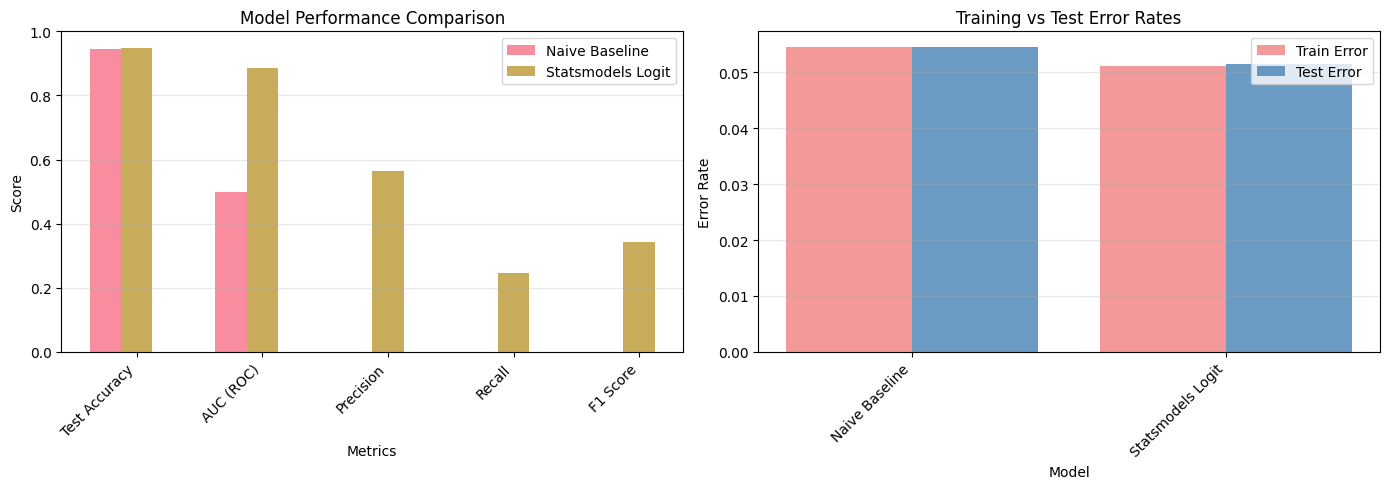

In [15]:
# Visualization: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
metrics_to_plot = ['Test Accuracy', 'AUC (ROC)', 'Precision', 'Recall', 'F1 Score']
x_pos = np.arange(len(metrics_to_plot))
width = 0.25

for i, model_name in enumerate(comparison_df['Model']):
    values = [comparison_df.iloc[i][metric] for metric in metrics_to_plot]
    axes[0].bar(x_pos + i*width, values, width, label=model_name, alpha=0.8)

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# Error rate comparison
train_errors = comparison_df['Train Error'].values
test_errors = comparison_df['Test Error'].values
models = comparison_df['Model'].values

x_pos2 = np.arange(len(models))
axes[1].bar(x_pos2 - 0.2, train_errors, 0.4, label='Train Error', color='lightcoral', alpha=0.8)
axes[1].bar(x_pos2 + 0.2, test_errors, 0.4, label='Test Error', color='steelblue', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Error Rate')
axes[1].set_title('Training vs Test Error Rates')
axes[1].set_xticks(x_pos2)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary

### Key Findings:

**Model Performance:**
- Test accuracy: ~94.8% vs naive baseline of 94.5%
- ROC-AUC: ~0.885 vs naive baseline of 0.50 (random guessing)
- The models show strong discriminative ability despite class imbalance

**Training vs Test Error:**
- Very similar training and test errors (~5.1-5.2%) indicate good generalization
- No evidence of overfitting despite using 121 features
- Statsmodels has slightly lower test error (0.0516 vs 0.0518)

**Classification Trade-offs:**
- High specificity (~98.9%) - excellent at identifying non-cases
- Low recall (~24.5%) - only captures about 1/4 of actual heart attack cases
- Moderate precision (~56%) - when model predicts positive, it's correct ~56% of the time
- This reflects the severe class imbalance (5.5% positive cases)

**Statistical Significance:**
- 56 out of 122 predictors (including intercept) are statistically significant (p < 0.05)
- Top predictors: HadAngina, Age categories, GeneralHealth, HadStroke
- Pseudo R² of 0.318 indicates moderate explanatory power
